# Object detection



__Prerequisite:
1. Tensorflow Object Detection
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md

__2. Dataset1
https://github.com/udacity/self-driving-car/tree/master/annotations

__Import dataset and split the annotated data into train data and test data

In [1]:
import pandas as pd

In [3]:
dataset = pd.read_csv('labels.csv', usecols=[ 'xmin','ymin','xmax','ymax','Frame','Label'])

In [4]:
train, test = dataset[:64855][:], dataset[64855:][:]
train.to_csv('train.csv', index = False)
test.to_csv('test.csv', index = False)

__Convert .csv files into tfrecord 

Modify source code from: https://github.com/datitran/raccoon_dataset/blob/master/generate_tfrecord.py

In [6]:
%%writefile generate_tfrecord.py
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

import os
import io
import pandas as pd
import tensorflow as tf

from PIL import Image
from object_detection.utils import dataset_util
from collections import namedtuple, OrderedDict

flags = tf.app.flags
flags.DEFINE_string('csv_input', '', 'Path to the CSV input')
flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
flags.DEFINE_string('image_dir', '', 'Path to images')
FLAGS = flags.FLAGS


def class_text_to_int(row_label):
    if row_label == 'Car':
        return 1
    elif row_label == 'Truck':
        return 2
    elif row_label == 'Pedestrian':
        return 3
    else:
        None


def split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, path):
    with tf.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        xmins.append(row['xmin'] / width)
        xmaxs.append(row['xmax'] / width)
        ymins.append(row['ymin'] / height)
        ymaxs.append(row['ymax'] / height)
        classes_text.append(row['Label'].encode('utf8'))
        classes.append(class_text_to_int(row['Label']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example


def main(_):
    writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    path = os.path.join(FLAGS.image_dir)
    examples = pd.read_csv(FLAGS.csv_input)
    grouped = split(examples, 'Frame')
    for group in grouped:
        tf_example = create_tf_example(group, path)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), FLAGS.output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


if __name__ == '__main__':
    tf.app.run()

Writing generate_tfrecord.py


__Construct label_map.pbtxt file

In [7]:
%%writefile label_map.pbtxt
item {
    id: 1
    name: 'Car'
}

item {
    id: 2
    name: 'Truck'
}

item {
    id: 3
    name: 'Pedestrian'
}

Writing label_map.pbtxt


In [9]:
!python3 generate_tfrecord.py\
    --csv_input=train.csv\
    --output_path=train.record
!python3 generate_tfrecord.py\
    --csv_input=test.csv\
    --output_path=test.record

Traceback (most recent call last):
  File "generate_tfrecord.py", line 94, in <module>
    tf.app.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/platform/app.py", line 125, in run
    _sys.exit(main(argv))
  File "generate_tfrecord.py", line 85, in main
    tf_example = create_tf_example(group, path)
  File "generate_tfrecord.py", line 40, in create_tf_example
    encoded_jpg = fid.read()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/lib/io/file_io.py", line 125, in read
    self._preread_check()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/lib/io/file_io.py", line 85, in _preread_check
    compat.as_bytes(self.__name), 1024 * 512, status)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCod

__Download pre-trained model (faster_rcnn_resnet101_coco)

In [10]:
!wget http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
!tar -xvf faster_rcnn_resnet101_coco_2018_01_28.tar.gz

--2019-04-16 16:20:30--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 216.58.195.80
Connecting to download.tensorflow.org (download.tensorflow.org)|216.58.195.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 593445323 (566M) [application/x-tar]
Saving to: 'faster_rcnn_resnet101_coco_2018_01_28.tar.gz'

faster_rcnn_resnet1 100%[===================>] 565.95M  20.0MB/s    in 37s     

2019-04-16 16:21:08 (15.1 MB/s) - 'faster_rcnn_resnet101_coco_2018_01_28.tar.gz' saved [593445323/593445323]

x faster_rcnn_resnet101_coco_2018_01_28/
x faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.index
x faster_rcnn_resnet101_coco_2018_01_28/checkpoint
x faster_rcnn_resnet101_coco_2018_01_28/pipeline.config
x faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.data-00000-of-00001
x faster_rcnn_resnet101_coco_2018_01_28/model.ckpt.meta
x faster_rcnn_resnet101_coco

__Prepare pipline config (faster_rcnn_resnet101_coco.config)

In [12]:
%%writefile pipeline.config
model {
  faster_rcnn {
    num_classes: 3
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 600
        max_dimension: 1024
      }
    }
    feature_extractor {
      type: 'faster_rcnn_resnet101'
      first_stage_features_stride: 16
    }
    first_stage_anchor_generator {
      grid_anchor_generator {
        scales: [0.25, 0.5, 1.0, 2.0]
        aspect_ratios: [0.5, 1.0, 2.0]
        height_stride: 16
        width_stride: 16
      }
    }
    first_stage_box_predictor_conv_hyperparams {
      op: CONV
      regularizer {
        l2_regularizer {
          weight: 0.0
        }
      }
      initializer {
        truncated_normal_initializer {
          stddev: 0.01
        }
      }
    }
    first_stage_nms_score_threshold: 0.0
    first_stage_nms_iou_threshold: 0.7
    first_stage_max_proposals: 300
    first_stage_localization_loss_weight: 2.0
    first_stage_objectness_loss_weight: 1.0
    initial_crop_size: 14
    maxpool_kernel_size: 2
    maxpool_stride: 2
    second_stage_box_predictor {
      mask_rcnn_box_predictor {
        use_dropout: false
        dropout_keep_probability: 1.0
        fc_hyperparams {
          op: FC
          regularizer {
            l2_regularizer {
              weight: 0.0
            }
          }
          initializer {
            variance_scaling_initializer {
              factor: 1.0
              uniform: true
              mode: FAN_AVG
            }
          }
        }
      }
    }
    second_stage_post_processing {
      batch_non_max_suppression {
        score_threshold: 0.0
        iou_threshold: 0.6
        max_detections_per_class: 100
        max_total_detections: 300
      }
      score_converter: SOFTMAX
    }
    second_stage_localization_loss_weight: 2.0
    second_stage_classification_loss_weight: 1.0
  }
}

train_config: {
  batch_size: 1
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        manual_step_learning_rate {
          initial_learning_rate: 0.0003
          schedule {
            step: 900000
            learning_rate: .00003
          }
          schedule {
            step: 1200000
            learning_rate: .000003
          }
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  gradient_clipping_by_norm: 10.0
  fine_tune_checkpoint: "faster_rcnn_resnet101_coco_2018_01_28/model.ckpt"
  # fine_tune_checkpoint: "modeloutput/model.ckpt-XXXXX"
  from_detection_checkpoint: true
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
}

train_input_reader: {
  tf_record_input_reader {
    input_path: "object-detection-crowdai/train.record"
  }
  label_map_path: "label_map.pbtxt"
}

eval_config: {
  num_examples: 8000
  # Note: The below line limits the evaluation process to 10 evaluations.
  # Remove the below line to evaluate indefinitely.
  max_evals: 10
}

eval_input_reader: {
  tf_record_input_reader {
    input_path: "object-detection-crowdai/test.record"
  }
  label_map_path: "label_map.pbtxt"
  shuffle: false
  num_readers: 1
}

Writing pipeline.config


__Train model

In [15]:
%%time
PIPELINE_CONFIG_PATH='pipeline.config'
MODEL_DIR='modeloutput'
NUM_TRAIN_STEPS=50000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1
!python3 /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/models/research/object_detection/model_main.py \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --model_dir={MODEL_DIR} \
    --num_train_steps={NUM_TRAIN_STEPS} \
    --sample_1_of_n_eval_examples={SAMPLE_1_OF_N_EVAL_EXAMPLES} \
    --alsologtostderr


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/models/research/object_detection/model_main.py", line 109, in <module>
    tf.app.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/platform/app.py", line 125, in run
    _sys.exit(main(argv))
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/models/research/object_detection/model_main.py", line 105, in main
    tf.estimator.train_and_evaluate(estimator, train_spec, eval

CPU times: user 40.9 ms, sys: 16.3 ms, total: 57.2 ms
Wall time: 3.8 s


__Export inference graph

In [16]:
!python3 /Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/models/research/object_detection/export_inference_graph.py \
    --input_type image_tensor \
    --pipeline_config_path={PIPELINE_CONFIG_PATH} \
    --trained_checkpoint_prefix model.ckpt-50000 \
    --output_directory exported_graphs

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_or_create_global_step
Instructions for updating:
Use `tf.profiler.profile(graph, run_meta, op_log, cmd, options)`. Build `options` with `tf.profiler.ProfileOptionBuilder`. See README.md for details
Instructions for updating:
Use tf.compat.v1.graph_util.remove_training_nodes
319 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops   

319 ops no flops stats due to incomplete shapes.
Parsing Inputs...
Incomplete shape.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          .*BatchNorm.*,.*Initializer.*,.*Regularizer.*,.*BiasAdd.*
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================
Incomplete shape.

Doc:
scope: The nodes in the model graph are organiz

2019-04-16 16:23:15.161934: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Instructions for updating:
Use standard file APIs to check for files with this prefix.
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/models/research/object_detection/export_inference_graph.py", line 156, in <module>
    tf.app.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/platform/app.py", line 125, in run
    _sys.exit(main(argv))
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/models/research/object_detection/export_inference_graph.py", line 152, in main
    write_inference_graph=FLAGS.write_inference_graph)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/models/researc

__Inference

Reference from: https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb

In [18]:
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

PATH_TO_FROZEN_GRAPH = 'faster_rcnn_resnet101_coco_2018_01_28/frozen_inference_graph.pb'
# load model
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
# load map
PATH_TO_LABELS = 'label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
# helper
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)
# detection
TEST_IMAGE_PATHS = ['object-detection-crowdai/' + p for p in ['1479506175971257681.jpg',
                                                              '1479505417440855375.jpg',
                                                              '1479505206426612895.jpg']]
IMAGE_SIZE = (64, 40)
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 1), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

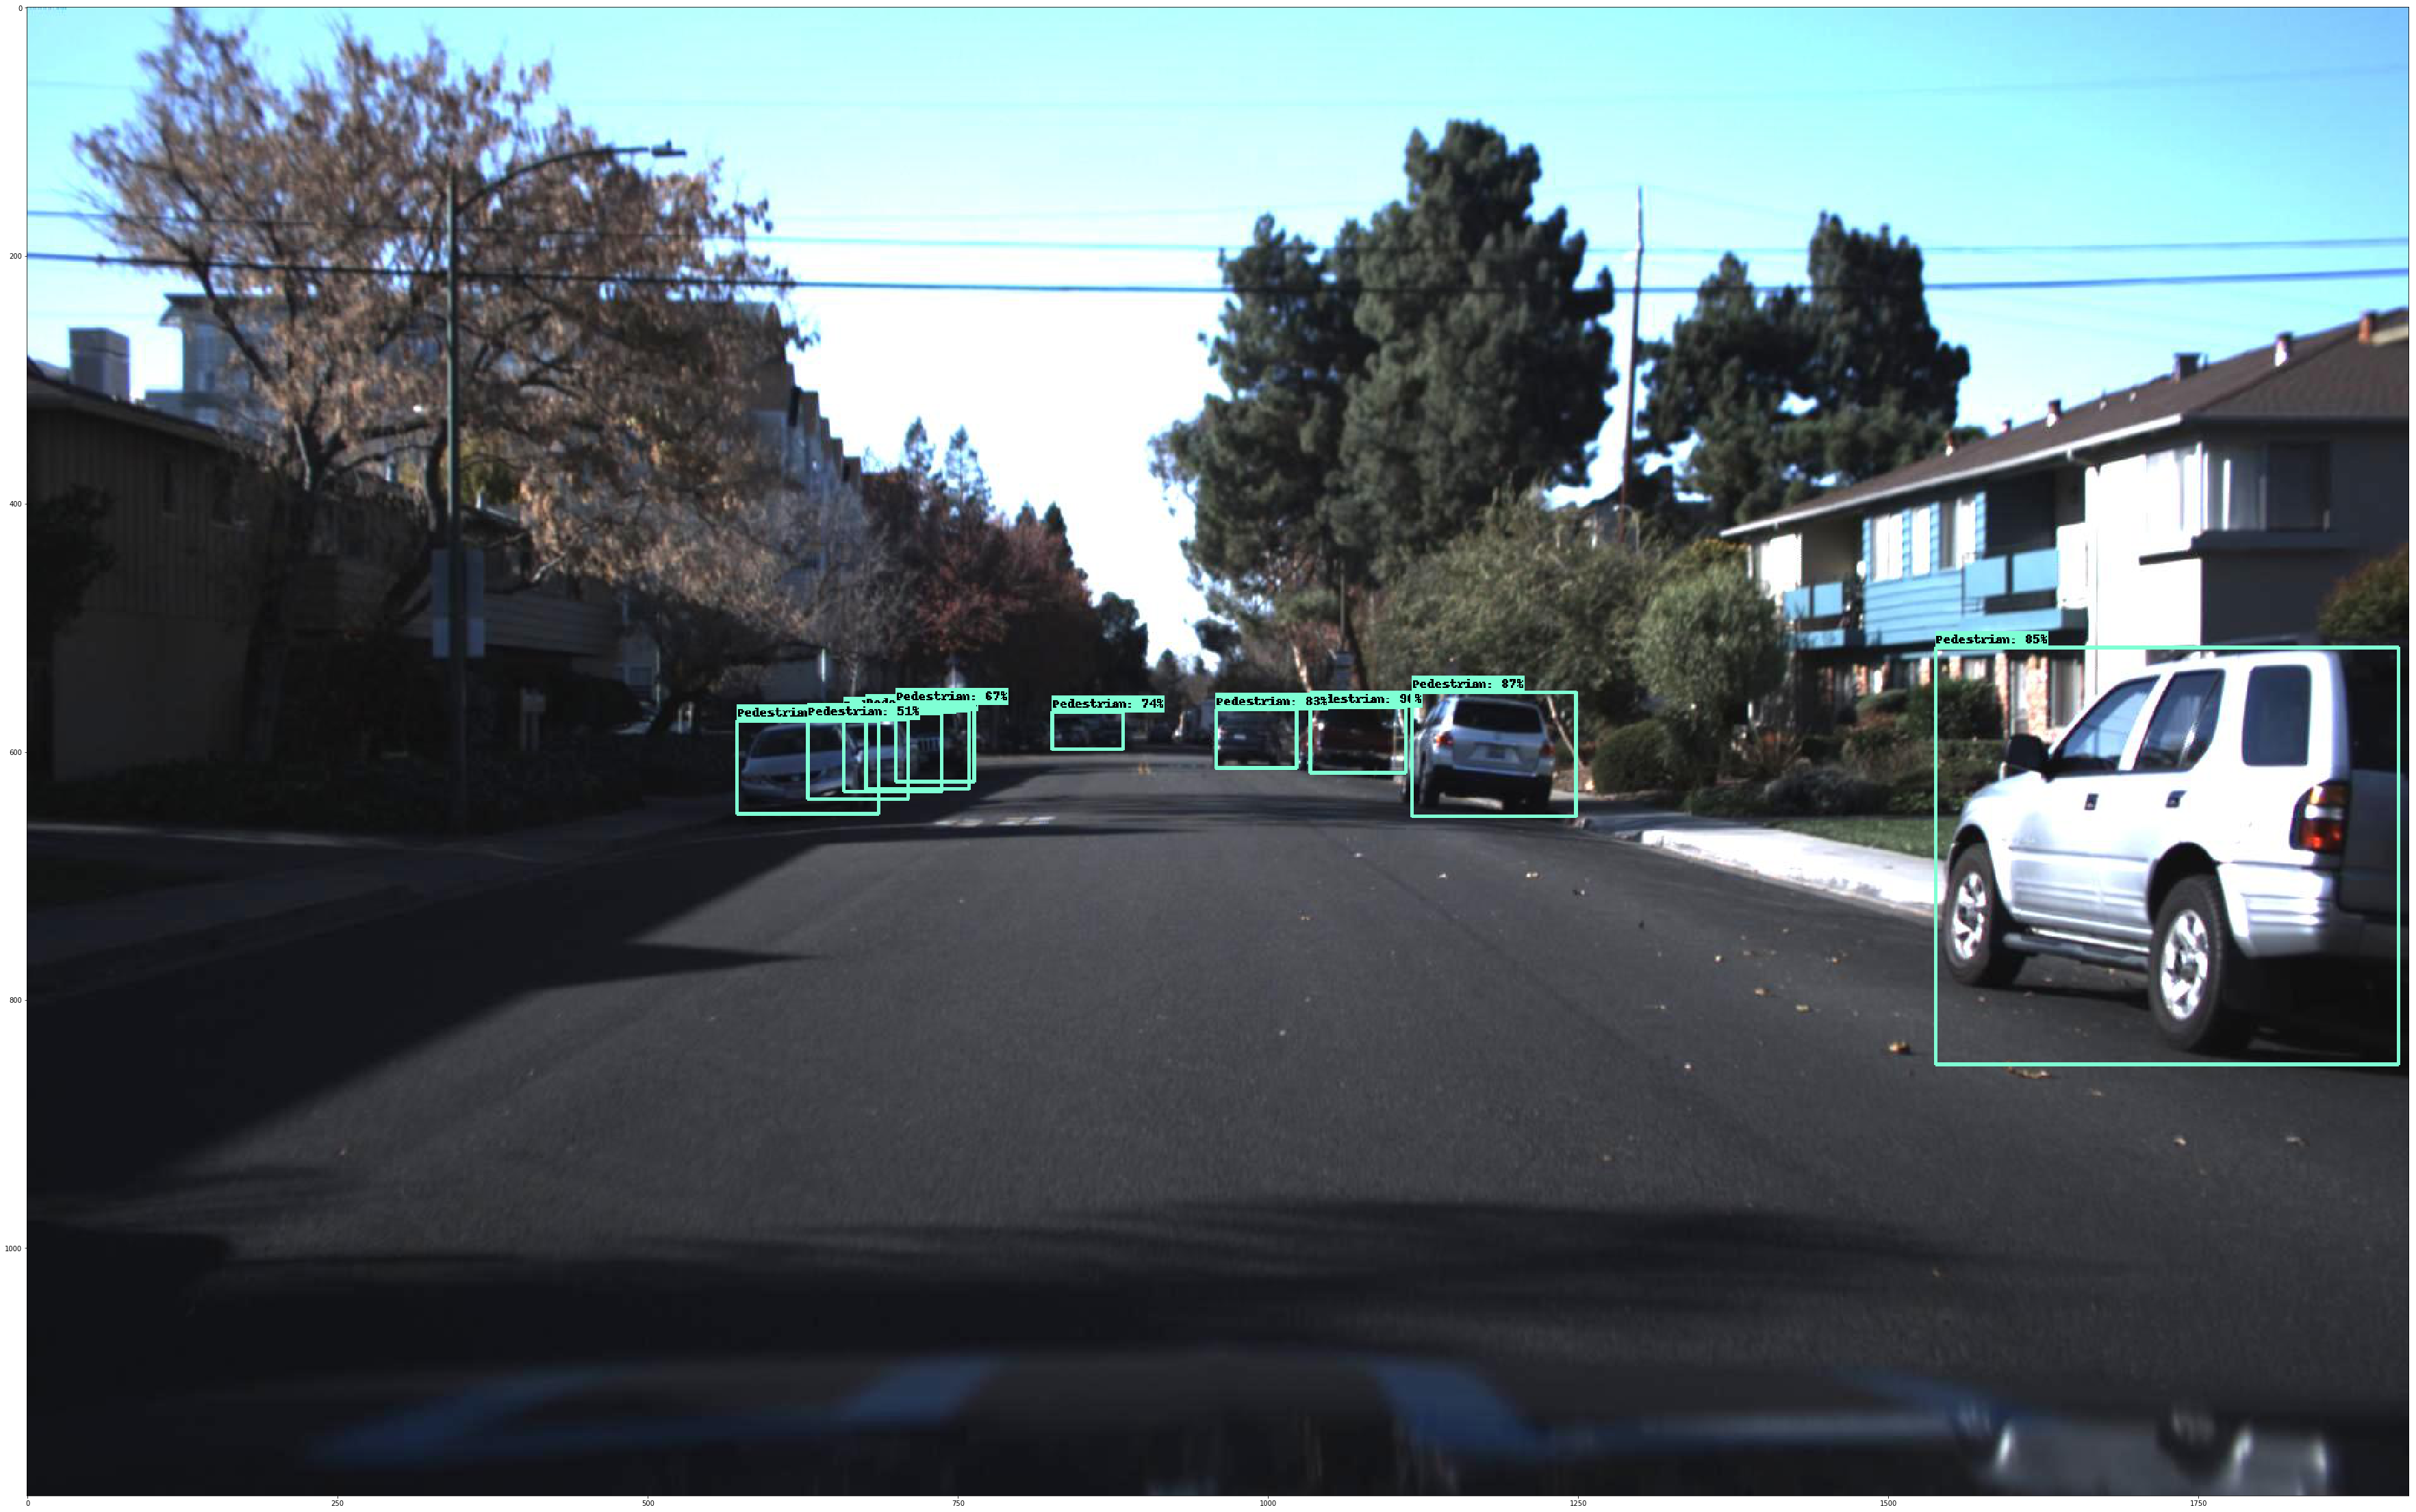

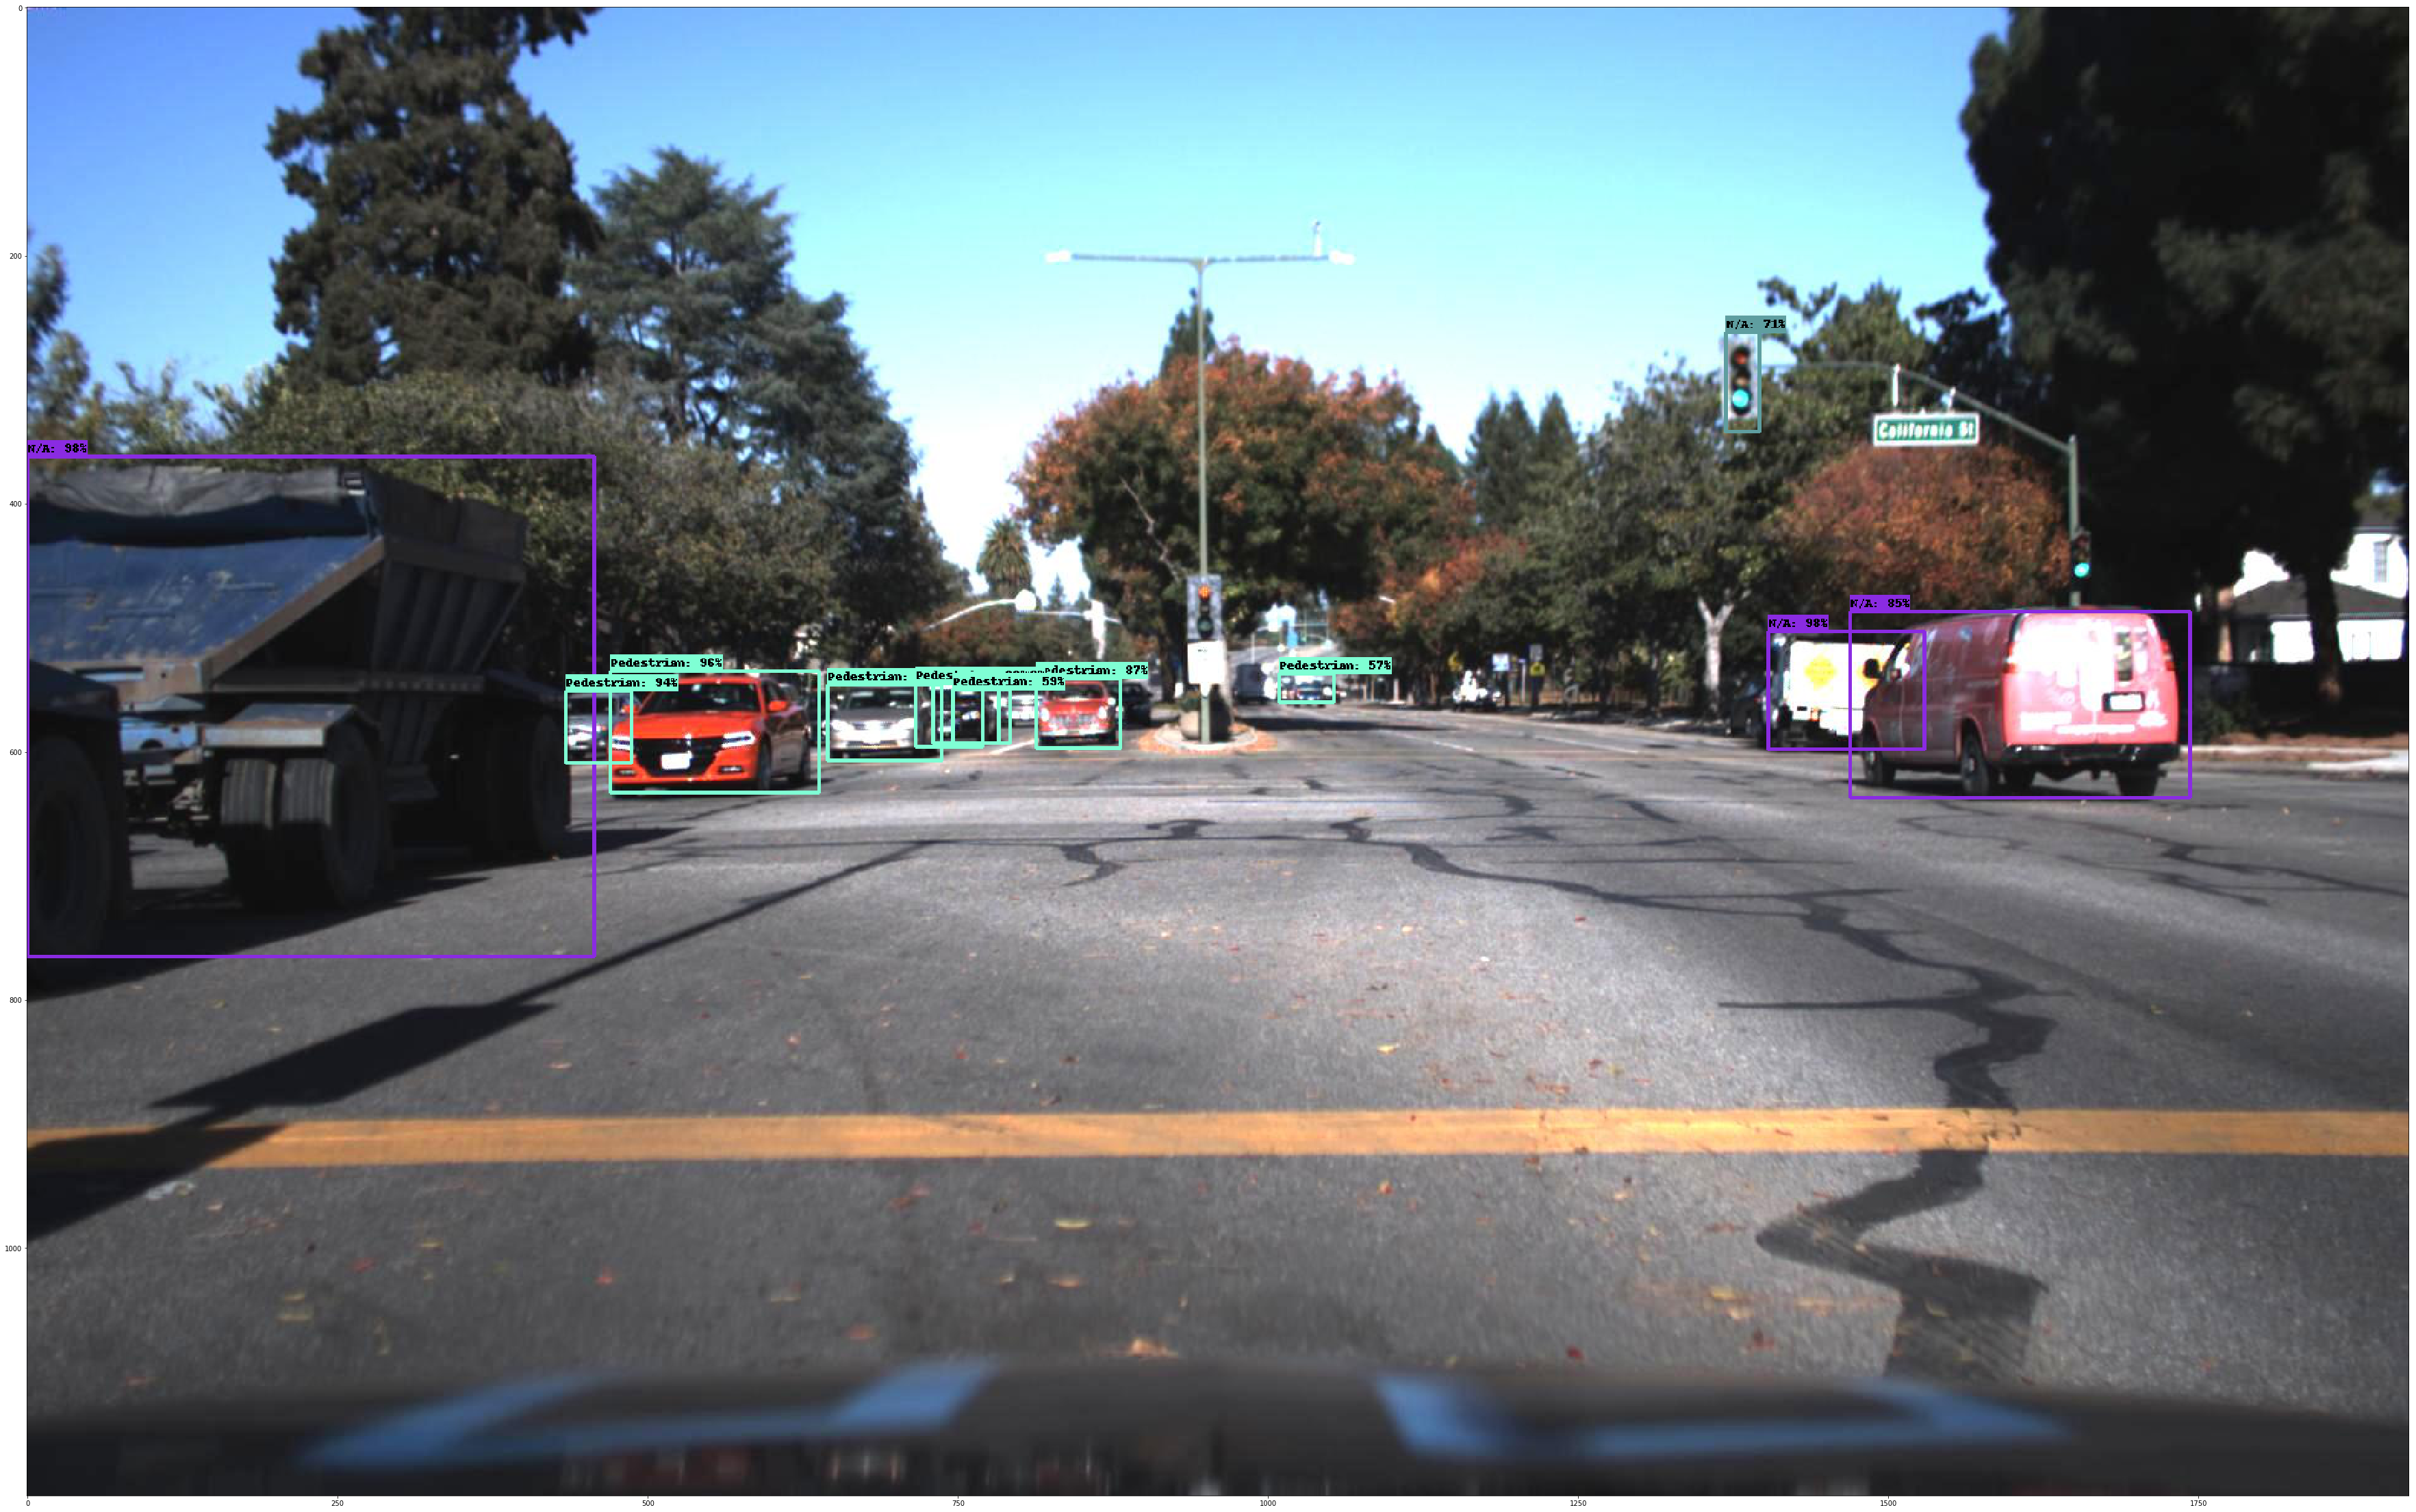

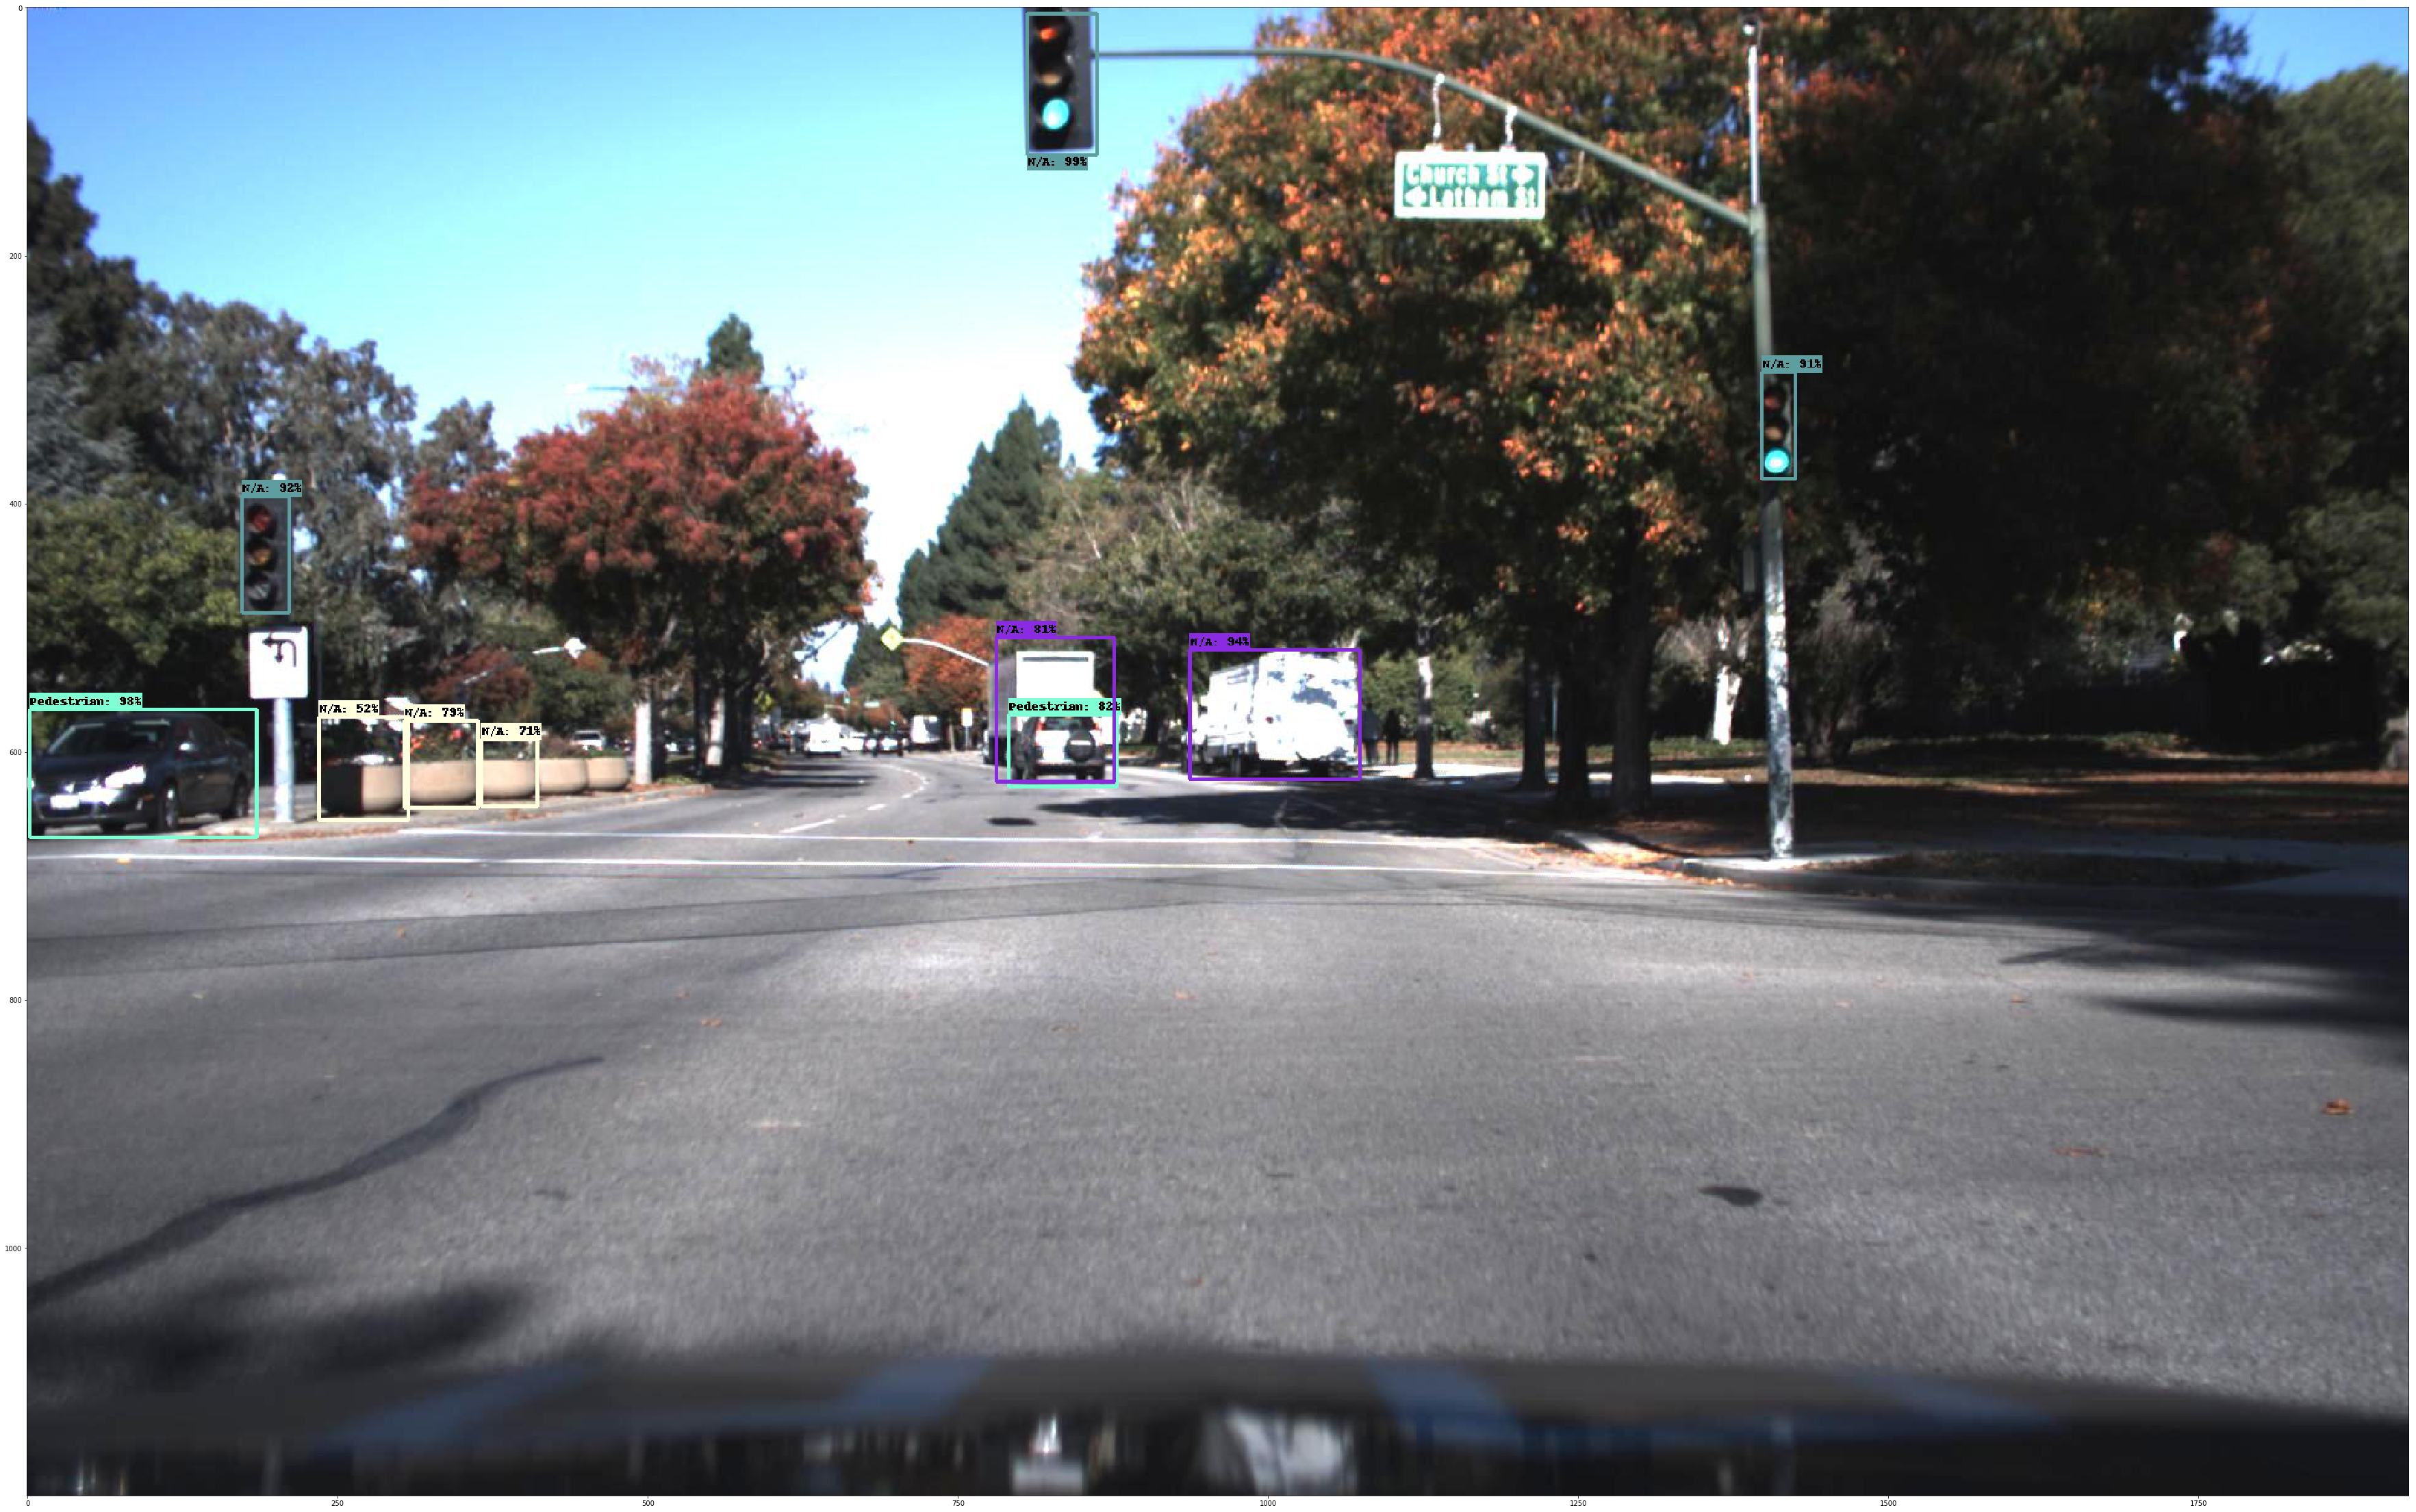

In [19]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=3)
#   plt.figure(dpi=600)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)